
--- Training Traditional DQN ---
[Traditional DQN] Adapting normalizer...
[Traditional DQN] Normalizer adapted with 1000 samples.
[Traditional DQN] Ep: 10/200 | Reward: 128.6 | Avg Rew (last 10): 129.8 | Energy: 85.2kJ | Completed: 50/50 | Violations: 0 | Epsilon: 0.951 | Avg Loss: 0.2334 | Duration: 13.19s
[Traditional DQN] Ep: 20/200 | Reward: 142.3 | Avg Rew (last 10): 137.4 | Energy: 82.0kJ | Completed: 50/50 | Violations: 0 | Epsilon: 0.905 | Avg Loss: 0.1533 | Duration: 12.87s
[Traditional DQN] Ep: 30/200 | Reward: 144.7 | Avg Rew (last 10): 137.7 | Energy: 81.1kJ | Completed: 50/50 | Violations: 0 | Epsilon: 0.860 | Avg Loss: 0.0381 | Duration: 13.18s
[Traditional DQN] Ep: 40/200 | Reward: 148.9 | Avg Rew (last 10): 139.1 | Energy: 79.3kJ | Completed: 50/50 | Violations: 0 | Epsilon: 0.818 | Avg Loss: 0.0202 | Duration: 13.59s
[Traditional DQN] Ep: 50/200 | Reward: 143.0 | Avg Rew (last 10): 142.8 | Energy: 81.6kJ | Completed: 50/50 | Violations: 0 | Epsilon: 0.778 | Avg Loss: 

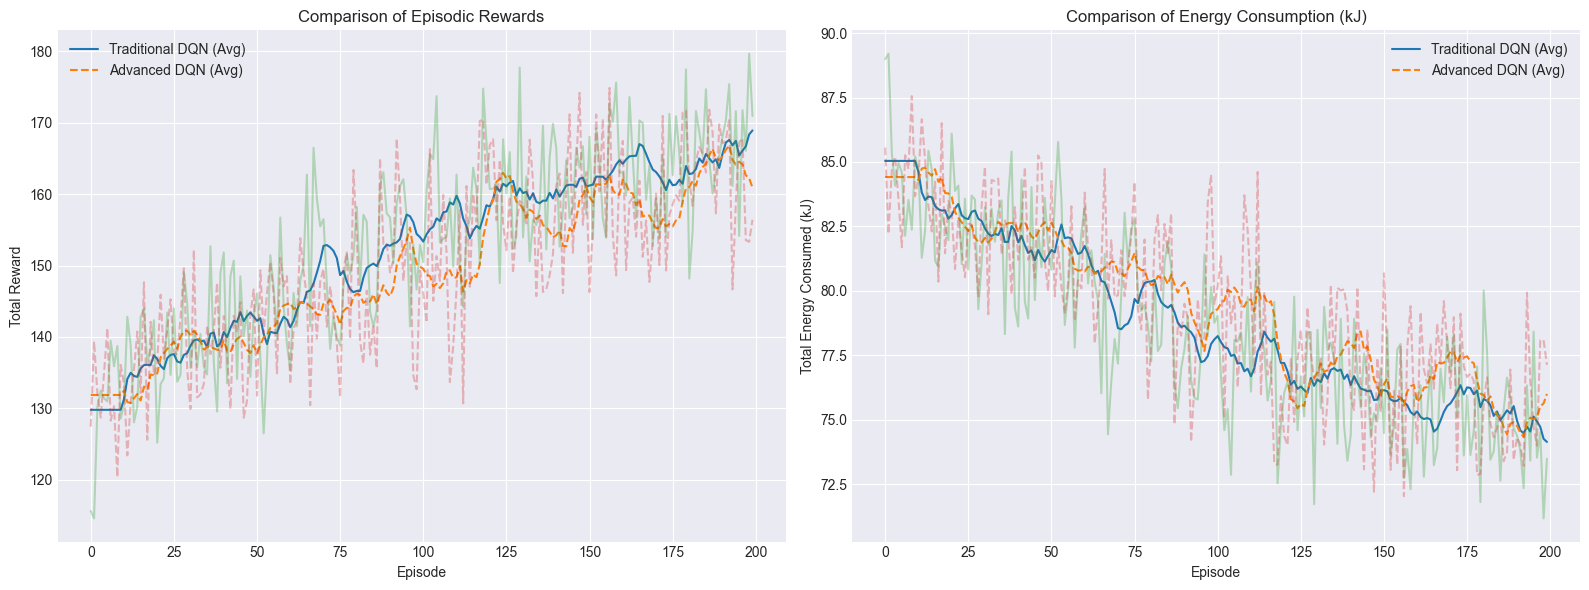

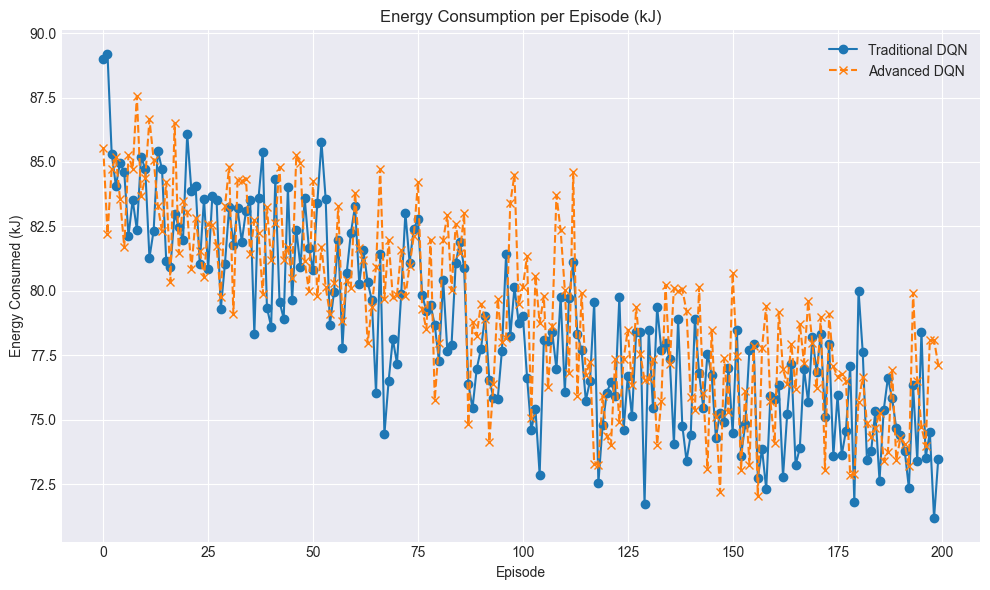


--- Final Average Results (last 50 episodes) ---
Traditional DQN:
  Avg Reward: 164.94
  Avg Energy (kJ): 75.17
  Avg Completion: 100.00%
Advanced DQN:
  Avg Reward: 160.48
  Avg Energy (kJ): 76.14
  Avg Completion: 100.00%


In [6]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os

# --- Common Components ---

class EnergyTracker:
    def __init__(self):
        # Use a reasonable estimate if TDP isn't known or fixed
        # Example: 45W for a higher-end laptop CPU under load
        self.CPU_TDP = 45  # Watts (Adjust based on your hardware if known)
        self.start_time = None
        self._process = psutil.Process(os.getpid())  # Get current process for CPU usage

    def start(self):
        self._process.cpu_percent()  # Call once to initialize measurement
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        # Get CPU usage specifically for the Python process and its children
        avg_cpu_usage = self._process.cpu_percent() / 100 / psutil.cpu_count()  # Normalize by core count
        # Estimate energy based on TDP and average usage during the tracked duration
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration  # Energy in Joules
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,  # Placeholder if only CPU is tracked
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity, initial_alpha=0.6, dynamic_alpha=False):
        self.capacity = capacity
        self.initial_alpha = initial_alpha
        self.dynamic_alpha = dynamic_alpha  # Flag to control alpha adjustment
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float64)  # Use float64 for precision
        self.pos = 0
        self.max_priority = 1.0

    def add(self, experience):
        priority = self.max_priority  # Assign max priority to new experiences
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
            self.priorities[self.pos] = priority**self.initial_alpha  # Store priority^alpha
        else:
            self.buffer[self.pos] = experience
            self.priorities[self.pos] = priority**self.initial_alpha  # Store priority^alpha
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, episode, total_episodes, beta=0.4):
        current_alpha = self.initial_alpha
        if self.dynamic_alpha:
            # Linearly increase alpha from 0.4 to 0.7 over training duration
            current_alpha = 0.4 + 0.3 * min(1.0, episode / total_episodes)

        num_samples = len(self.buffer)
        if num_samples == 0:
             return [], [], np.array([])  # Handle empty buffer case

        sampling_priorities = self.priorities[:num_samples] ** current_alpha
        prob = sampling_priorities / np.sum(sampling_priorities)

        if np.any(np.isnan(prob)) or np.sum(prob) == 0:
             prob = np.ones(num_samples) / num_samples
             print(f"Warning: Invalid probabilities detected (sum={np.sum(sampling_priorities)}). Falling back to uniform sampling.")

        indices = np.random.choice(num_samples, batch_size, p=prob, replace=True)
        samples = [self.buffer[idx] for idx in indices]

        weights = (num_samples * prob[indices]) ** (-beta)
        weights /= np.max(weights)  # Normalize weights

        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, td_errors, epsilon=1e-6):
        priorities = np.abs(td_errors) + epsilon  # Add small epsilon for stability
        for idx, priority in zip(indices, priorities):
             if idx < len(self.buffer):  # Ensure index is valid
                self.priorities[idx] = priority
                self.max_priority = max(self.max_priority, priority)

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        self.VOLTAGE_MD = 3.7
        self.VOLTAGE_ES = 12.0
        self.MAH_TO_J = 3.6
        self.operations_per_mb = 1e9  # Assuming 1 Giga-operation per MB

        # Reward parameters
        self.task_reward = 8.0
        self.energy_penalty_scale = 0.0015  # Increased penalty sensitivity
        self.budget_penalty = 12.0
        self.efficiency_bonus = 2.0  # Bonus for low energy use per task
        self.low_energy_threshold = 500  # Joules

        # System parameters (will be randomized in reset)
        self.md_compute = None
        self.es_compute = None
        self.task_requirements = None
        self.task_to_md = None
        self.md_energy_local = None  # Energy per operation (J/op)
        self.md_energy_tx = None     # Energy per MB transmitted (J/MB)
        self.es_energy_process = None  # Energy per operation (J/op)

        # State variables (will be initialized in reset)
        self.md_battery = None
        self.es_battery = None
        self.initial_md_battery_joules = None
        self.initial_es_battery_joules = None
        self.energy_budget = 10000 * 1000  # Joules (10000 kJ)
        self.total_energy_consumed = 0
        self.current_task = 0
        self.completed_tasks = 0
        self.violations = 0
        self.local_task_count = 0
        self.edge_task_count = 0

        # Battery history for trend analysis (optional feature)
        self.md_battery_history = deque(maxlen=3)
        self.es_battery_history = deque(maxlen=3)

        self.state_shape = None
        self.action_size = 1 + self.num_es  # 0 for local, 1 to num_es for edge servers
        self.reset(initial_call=True)  # Initialize parameters on creation

    def reset(self, initial_call=False):
        if initial_call:
            self.md_compute = np.random.uniform(1.5, 3.5, self.num_md)
            self.es_compute = np.random.uniform(25.0, 35.0, self.num_es)
            self.task_requirements = np.random.randint(150, 600, self.num_tasks)
            self.task_to_md = np.random.randint(0, self.num_md, self.num_tasks)
            self.md_energy_local = np.random.uniform(3.0, 6.0, self.num_md)
            self.md_energy_tx = np.random.uniform(0.5, 1.5, self.num_md)
            self.es_energy_process = np.random.uniform(2.5, 5.0, self.num_es)

        initial_md_battery_mah = np.random.randint(3500, 5501, self.num_md)
        initial_es_battery_mah = np.random.randint(12000, 25001, self.num_es)
        self.initial_md_battery_joules = initial_md_battery_mah * self.MAH_TO_J * self.VOLTAGE_MD
        self.initial_es_battery_joules = initial_es_battery_mah * self.MAH_TO_J * self.VOLTAGE_ES

        self.md_battery = self.initial_md_battery_joules.copy()
        self.es_battery = self.initial_es_battery_joules.copy()

        self.total_energy_consumed = 0
        self.current_task = 0
        self.completed_tasks = 0
        self.violations = 0
        self.local_task_count = 0
        self.edge_task_count = 0

        self.md_battery_history.clear()
        self.es_battery_history.clear()
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        initial_state = self._get_state()
        if self.state_shape is None:
             self.state_shape = initial_state.shape
             print(f"State shape initialized: {self.state_shape}")

        return initial_state

    def _get_state(self):
        if self.current_task >= self.num_tasks:
             if self.state_shape:
                return np.zeros(self.state_shape, dtype=np.float32)
             else:
                 fallback_size = 7 + self.num_es * 5 + 2
                 return np.zeros(fallback_size, dtype=np.float32)

        md_idx = self.task_to_md[self.current_task]
        task_size_mb = self.task_requirements[self.current_task]
        task_ops_giga = task_size_mb * self.operations_per_mb / 1e9

        max_md_energy = np.max(self.initial_md_battery_joules) if self.initial_md_battery_joules is not None else 5500 * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = np.max(self.initial_es_battery_joules) if self.initial_es_battery_joules is not None else 25000 * self.MAH_TO_J * self.VOLTAGE_ES
        max_md_compute = 3.5
        max_es_compute = 35.0
        max_task_size = 600
        max_md_local_e = 6.0
        max_md_tx_e = 1.5
        max_es_process_e = 5.0

        md_trend = 0
        if len(self.md_battery_history) > 1:
            diffs = [(self.md_battery_history[i][md_idx] - self.md_battery_history[i-1][md_idx])
                     for i in range(1, len(self.md_battery_history))]
            md_trend = np.mean(diffs) / max_md_energy

        es_trends = np.zeros(self.num_es)
        if len(self.es_battery_history) > 1:
            for es_idx in range(self.num_es):
                 diffs = [(self.es_battery_history[i][es_idx] - self.es_battery_history[i-1][es_idx])
                         for i in range(1, len(self.es_battery_history))]
                 es_trends[es_idx] = np.mean(diffs) / max_es_energy

        state = []
        state.extend([
            self.md_battery[md_idx] / max_md_energy,
            self.md_compute[md_idx] / max_md_compute,
            task_size_mb / max_task_size,
            task_ops_giga,
            self.md_energy_local[md_idx] / max_md_local_e,
            self.md_energy_tx[md_idx] / max_md_tx_e,
            md_trend
        ])

        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / max_es_energy,
                self.es_compute[es_idx] / max_es_compute,
                self.es_energy_process[es_idx] / max_es_process_e,
                es_trends[es_idx]
            ])

        state.extend([
            self.current_task / self.num_tasks,
            self.total_energy_consumed / self.energy_budget
        ])

        final_state = np.array(state, dtype=np.float32)
        if self.state_shape is None:
            self.state_shape = final_state.shape

        if self.state_shape and final_state.shape != self.state_shape:
             padded_state = np.zeros(self.state_shape, dtype=np.float32)
             pad_len = min(len(final_state), self.state_shape[0])
             padded_state[:pad_len] = final_state[:pad_len]
             return padded_state

        return final_state

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return self._get_state(), 0, True, {}

        md_idx = self.task_to_md[self.current_task]
        task_size_mb = self.task_requirements[self.current_task]
        task_ops_giga = task_size_mb * self.operations_per_mb / 1e9

        energy_used_joules = 0
        reward = 0
        info = {"file_size_MB": task_size_mb, "processed_at": "Failed"}

        try:
            if action == 0:  # --- Local Processing ---
                self.local_task_count += 1
                energy_needed = task_ops_giga * self.md_energy_local[md_idx]
                if self.md_battery[md_idx] >= energy_needed:
                    self.md_battery[md_idx] -= energy_needed
                    energy_used_joules = energy_needed
                    self.completed_tasks += 1
                    info["processed_at"] = f"MD{md_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError(f"Insufficient MD energy for local processing (Task {self.current_task})")
            else:  # --- Offload Processing ---
                self.edge_task_count += 1
                es_idx = action - 1
                if es_idx >= self.num_es:
                     raise ValueError(f"Invalid action: ES index {es_idx} out of bounds.")
                tx_energy = task_size_mb * self.md_energy_tx[md_idx]
                process_energy = task_ops_giga * self.es_energy_process[es_idx]
                energy_needed_md = tx_energy
                energy_needed_es = process_energy
                if self.md_battery[md_idx] >= energy_needed_md and self.es_battery[es_idx] >= energy_needed_es:
                    self.md_battery[md_idx] -= energy_needed_md
                    self.es_battery[es_idx] -= energy_needed_es
                    energy_used_joules = energy_needed_md + energy_needed_es
                    self.completed_tasks += 1
                    info["processed_at"] = f"ES{es_idx}"
                else:
                    self.violations += 1
                    fail_reason = []
                    if self.md_battery[md_idx] < energy_needed_md: fail_reason.append("MD_Tx")
                    if self.es_battery[es_idx] < energy_needed_es: fail_reason.append("ES_Process")
                    raise RuntimeError(f"Insufficient energy for offload (Task {self.current_task}). Failed: {', '.join(fail_reason)}")

            reward = self.task_reward
            energy_penalty = (energy_used_joules ** 1.1) * self.energy_penalty_scale
            reward -= energy_penalty
            if energy_used_joules < self.low_energy_threshold:
                reward += self.efficiency_bonus

        except (RuntimeError, ValueError) as e:
            reward = -self.task_reward

        self.total_energy_consumed += energy_used_joules
        if self.total_energy_consumed > self.energy_budget:
            reward -= self.budget_penalty
            info["budget_exceeded"] = True

        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())
        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()

        info["energy_used_J"] = energy_used_joules
        return next_state, reward, done, info

# --- Agent Definitions ---

class TraditionalDQNAgent:
    def __init__(self, state_size, action_size, total_episodes=100):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = None
        self.batch_size = 256
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        self.tau = 0.12
        self.beta = 0.4
        self.network_layers = [256, 128]
        self.total_episodes = total_episodes

        self.normalizer = tf.keras.layers.Normalization(axis=-1)
        self.model = self._build_network()
        self.target_model = self._build_network()
        self.update_target_network()

    def _build_network(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = self.normalizer(inputs)
        for units in self.network_layers:
            x = tf.keras.layers.Dense(units, activation='relu')(x)
        outputs = tf.keras.layers.Dense(self.action_size, activation='linear')(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss=tf.keras.losses.Huber()
        )
        return model

    def update_target_network(self):
        q_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        new_weights = []
        for q_w, t_w in zip(q_weights, target_weights):
            new_weights.append(self.tau * q_w + (1 - self.tau) * t_w)
        self.target_model.set_weights(new_weights)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
         if self.memory is not None:
            self.memory.add((state, action, reward, next_state, done))
         else:
             print("Warning: Agent memory not initialized.")

    def replay(self, episode):
        if self.memory is None or len(self.memory.buffer) < self.batch_size:
            return 0.0

        samples, indices, weights = self.memory.sample(
            self.batch_size, episode, self.total_episodes, self.beta
        )
        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states)
        next_states = np.array(next_states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)
        weights = np.array(weights)

        target_next_q_values = self.target_model.predict(next_states, verbose=0)
        best_next_q_values = np.max(target_next_q_values, axis=1)
        target_q_values = rewards + (1 - dones) * self.gamma * best_next_q_values

        current_q_values = self.model.predict(states, verbose=0)
        action_indices = np.arange(self.batch_size)
        q_value_for_action = current_q_values[action_indices, actions]
        td_errors = np.abs(target_q_values - q_value_for_action)
        self.memory.update_priorities(indices, td_errors)

        target_q_for_training = current_q_values.copy()
        target_q_for_training[action_indices, actions] = target_q_values

        history = self.model.fit(
            states,
            target_q_for_training,
            batch_size=self.batch_size,
            sample_weight=weights,
            epochs=1,
            verbose=0
        )
        self.update_target_network()
        return history.history['loss'][0]

class AdvancedDQNAgent:
    def __init__(self, state_size, action_size, total_episodes=100):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = None
        self.batch_size = 256
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        self.tau = 0.12
        self.beta = 0.4
        self.beta_annealing = (1.0 - 0.4) / total_episodes
        self.network_layers = [256, 128]
        self.total_episodes = total_episodes

        self.normalizer = tf.keras.layers.Normalization(axis=-1)
        self.model = self._build_network()
        self.target_model = self._build_network()
        self.update_target_network()

    def _build_network(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = self.normalizer(inputs)
        for units in self.network_layers:
            x = tf.keras.layers.Dense(units, activation='swish')(x)
            x = tf.keras.layers.LayerNormalization()(x)
            x = tf.keras.layers.Dropout(0.2)(x)
        value_stream = tf.keras.layers.Dense(64, activation='swish')(x)
        value = tf.keras.layers.Dense(1, name='value')(value_stream)
        advantage_stream = tf.keras.layers.Dense(64, activation='swish')(x)
        advantage = tf.keras.layers.Dense(self.action_size, name='advantage')(advantage_stream)
        def combine_streams(streams):
            v, a = streams
            mean_advantage = tf.reduce_mean(a, axis=1, keepdims=True)
            return v + (a - mean_advantage)
        outputs = tf.keras.layers.Lambda(combine_streams, name='q_values')([value, advantage])
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0),
            loss=tf.keras.losses.Huber()
        )
        return model

    def update_target_network(self):
        q_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        new_weights = []
        for q_w, t_w in zip(q_weights, target_weights):
            new_weights.append(self.tau * q_w + (1 - self.tau) * t_w)
        self.target_model.set_weights(new_weights)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
         if self.memory is not None:
            self.memory.add((state, action, reward, next_state, done))
         else:
             print("Warning: Agent memory not initialized.")

    def replay(self, episode):
        if self.memory is None or len(self.memory.buffer) < self.batch_size:
            return 0.0

        current_beta = min(1.0, self.beta + episode * self.beta_annealing)
        samples, indices, weights = self.memory.sample(
            self.batch_size, episode, self.total_episodes, current_beta
        )
        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states)
        next_states = np.array(next_states)
        actions = np.array(actions, dtype=np.int32)
        rewards = np.array(rewards)
        dones = np.array(dones)
        weights = np.array(weights)

        next_q_values_main = self.model.predict(next_states, verbose=0)
        best_next_actions = np.argmax(next_q_values_main, axis=1)
        next_q_values_target = self.target_model.predict(next_states, verbose=0)
        best_next_q_values = next_q_values_target[np.arange(self.batch_size), best_next_actions]
        target_q_values = rewards + (1 - dones) * self.gamma * best_next_q_values

        current_q_values = self.model.predict(states, verbose=0)
        action_indices = np.arange(self.batch_size)
        q_value_for_action = current_q_values[action_indices, actions]
        td_errors = np.abs(target_q_values - q_value_for_action)
        self.memory.update_priorities(indices, td_errors)

        target_q_for_training = current_q_values.copy()
        target_q_for_training[action_indices, actions] = target_q_values

        history = self.model.fit(
            states,
            target_q_for_training,
            batch_size=self.batch_size,
            sample_weight=weights,
            epochs=1,
            verbose=0
        )
        self.update_target_network()
        return history.history['loss'][0]

# --- Training Orchestration ---

def train_agent(agent_class, buffer_config, env, episodes, agent_name):
    print(f"\n--- Training {agent_name} ---")
    tracker = EnergyTracker()
    state_size = env.state_shape[0]
    action_size = env.action_size

    agent = agent_class(state_size, action_size, episodes)
    agent.memory = PrioritizedReplayBuffer(capacity=100000, **buffer_config)

    print(f"[{agent_name}] Adapting normalizer...")
    states_for_adapt = []
    state = env.reset()
    for _ in range(2000):
        action = np.random.randint(action_size)
        if state is not None and state.shape == env.state_shape:
            states_for_adapt.append(state)
        next_state, _, done, _ = env.step(action)
        if done:
            state = env.reset()
        else:
            state = next_state
        if len(states_for_adapt) >= 1000:
            break

    if states_for_adapt:
         agent.normalizer.adapt(np.array(states_for_adapt))
         print(f"[{agent_name}] Normalizer adapted with {len(states_for_adapt)} samples.")
    else:
         print(f"[{agent_name}] Warning: No valid states collected for normalizer adaptation.")

    all_rewards = []
    all_energy_consumptions_kj = []
    all_completion_rates = []
    all_epsilons = []
    all_energy_values = []  # Store per-episode energy values for this agent
    losses = deque(maxlen=100)
    start_total_time = time.time()

    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        total_reward = 0
        done = False
        steps = 0
        episode_loss_sum = 0
        episode_loss_count = 0

        while not done:
            if state is None or state.shape != env.state_shape:
                 print(f"[{agent_name}] Warning: Invalid state detected in episode {episode + 1}, step {steps}. Resetting episode.")
                 break

            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            if next_state is not None and next_state.shape == env.state_shape:
                 agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps += 1
            loss = agent.replay(episode)
            if loss > 0:
                episode_loss_sum += loss
                episode_loss_count += 1
                losses.append(loss)

        energy_metrics = tracker.stop()

        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay

        all_rewards.append(total_reward)
        all_energy_consumptions_kj.append(env.total_energy_consumed / 1000.0)
        all_completion_rates.append(env.completed_tasks / env.num_tasks)
        all_epsilons.append(agent.epsilon)
        all_energy_values.append(env.total_energy_consumed / 1000.0)  # Save energy for this episode

        avg_loss = np.mean(losses) if losses else 0
        if (episode + 1) % 10 == 0 or episode == episodes - 1:
            print(f"[{agent_name}] Ep: {episode + 1}/{episodes} | "
                  f"Reward: {total_reward:.1f} | "
                  f"Avg Rew (last 10): {np.mean(all_rewards[-10:]):.1f} | "
                  f"Energy: {env.total_energy_consumed / 1000.0:.1f}kJ | "
                  f"Completed: {env.completed_tasks}/{env.num_tasks} | "
                  f"Violations: {env.violations} | "
                  f"Epsilon: {agent.epsilon:.3f} | "
                  f"Avg Loss: {avg_loss:.4f} | "
                  f"Duration: {energy_metrics['duration']:.2f}s")
    end_total_time = time.time()
    print(f"[{agent_name}] Training finished in {end_total_time - start_total_time:.2f} seconds.")

    return {
        'rewards': all_rewards,
        'energy': all_energy_consumptions_kj,
        'completion': all_completion_rates,
        'epsilons': all_epsilons,
        'energy_values': all_energy_values,  # Add energy per episode array
        'name': agent_name
    }

# --- Main Execution and Plotting ---

if __name__ == "__main__":
    tf.keras.backend.clear_session()

    EPISODES = 200
    NUM_MD = 10
    NUM_ES = 4
    NUM_TASKS = 50

    env = MECEnvironment(num_md=NUM_MD, num_es=NUM_ES, num_tasks=NUM_TASKS)
    env.reset(initial_call=True)

    traditional_buffer_config = {'initial_alpha': 0.6, 'dynamic_alpha': False}
    advanced_buffer_config = {'initial_alpha': 0.6, 'dynamic_alpha': True}

    tf.keras.backend.clear_session()
    traditional_results = train_agent(
        agent_class=TraditionalDQNAgent,
        buffer_config=traditional_buffer_config,
        env=env,
        episodes=EPISODES,
        agent_name="Traditional DQN"
    )

    tf.keras.backend.clear_session()
    advanced_results = train_agent(
        agent_class=AdvancedDQNAgent,
        buffer_config=advanced_buffer_config,
        env=env,
        episodes=EPISODES,
        agent_name="Advanced DQN"
    )

    # --- Comparative Plotting of Rewards and Energy ---
    print("\n--- Plotting Comparative Results ---")
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='valid')
        return np.pad(y_smooth, (box_pts - 1, 0), 'edge')

    smoothing_window = 10

    axes[0].plot(smooth(traditional_results['rewards'], smoothing_window),
                 label=f"{traditional_results['name']} (Avg)")
    axes[0].plot(smooth(advanced_results['rewards'], smoothing_window),
                 label=f"{advanced_results['name']} (Avg)", linestyle='--')
    axes[0].plot(traditional_results['rewards'], alpha=0.3)
    axes[0].plot(advanced_results['rewards'], alpha=0.3, linestyle='--')
    axes[0].set_title('Comparison of Episodic Rewards')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Total Reward')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(smooth(traditional_results['energy'], smoothing_window),
                 label=f"{traditional_results['name']} (Avg)")
    axes[1].plot(smooth(advanced_results['energy'], smoothing_window),
                 label=f"{advanced_results['name']} (Avg)", linestyle='--')
    axes[1].plot(traditional_results['energy'], alpha=0.3)
    axes[1].plot(advanced_results['energy'], alpha=0.3, linestyle='--')
    axes[1].set_title('Comparison of Energy Consumption (kJ)')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Total Energy Consumed (kJ)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig("dqn_comparison_rewards_energy.png")
    plt.show()

    # --- Plotting Energy Values (Per Episode) for Each Agent ---
    plt.figure(figsize=(10, 6))
    plt.plot(traditional_results['energy_values'], label=traditional_results['name'], marker='o')
    plt.plot(advanced_results['energy_values'], label=advanced_results['name'], marker='x', linestyle='--')
    plt.title("Energy Consumption per Episode (kJ)")
    plt.xlabel("Episode")
    plt.ylabel("Energy Consumed (kJ)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("energy_consumption_per_episode.png")
    plt.show()

    # --- Final Average Results ---
    print("\n--- Final Average Results (last 50 episodes) ---")
    last_n = 50
    print(f"{traditional_results['name']}:")
    print(f"  Avg Reward: {np.mean(traditional_results['rewards'][-last_n:]):.2f}")
    print(f"  Avg Energy (kJ): {np.mean(traditional_results['energy'][-last_n:]):.2f}")
    print(f"  Avg Completion: {np.mean(traditional_results['completion'][-last_n:]):.2%}")

    print(f"{advanced_results['name']}:")
    print(f"  Avg Reward: {np.mean(advanced_results['rewards'][-last_n:]):.2f}")
    print(f"  Avg Energy (kJ): {np.mean(advanced_results['energy'][-last_n:]):.2f}")
    print(f"  Avg Completion: {np.mean(advanced_results['completion'][-last_n:]):.2%}")
